# PCA - parte 1

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

filename_features = "./input/features.txt"
filename_labels = "./input/activity_labels.txt"

filename_subtrain = "./input/train/subject_train.txt"
filename_xtrain = "./input/train/X_train.txt"
filename_ytrain = "./input/train/y_train.txt"

filename_subtest = "./input/test/subject_test.txt"
ffilename_xtest = "./input/test/X_test.txt"
filename_ytest = "./input/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
labels = pd.read_csv(filename_labels, sep=r'\s+', header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, sep=r'\s+', header=None, names=features.nome_var)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(ffilename_xtest, sep=r'\s+', header=None, names=features.nome_var)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

In [3]:
labels

,cod_label,label
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


In [4]:
subject_train.shape, X_train.shape, y_train.shape, 

((7352, 1), (7352, 561), (7352, 1))

In [5]:
subject_test.shape, X_test.shape, y_test.shape

((2947, 1), (2947, 561), (2947, 1))

In [6]:
# Ocorrência dos labels
y_train.value_counts()

cod_label
6            1407
5            1374
4            1286
1            1226
2            1073
3             986
Name: count, dtype: int64

## Árvore de decisão

Rode uma árvore de decisão com todas as variáveis, utilizando o ```ccp_alpha=0.001```. Avalie a acurácia nas bases de treinamento e teste. Avalie o tempo de processamento.

In [7]:
%%time

# Criando a árvore
clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
clf.fit(X_train, y_train)

# Avaliando o modelo
acc_train = clf.score(X_train, y_train)
acc_test = clf.score(X_test, y_test)

print('--> A acurácia do modelo na base de treino é {:.2f}%'.format(acc_train*100))
print('--> A acurácia do modelo na base de testes é {:.2f}%'.format(acc_test*100))

--> A acurácia do modelo na base de treino é 97.58%
--> A acurácia do modelo na base de testes é 87.95%
CPU times: total: 4.72 s
Wall time: 4.73 s


## Árvore com PCA

Faça uma análise de componemtes principais das variáveis originais. Utilize apenas uma componente. Faça uma árvore de decisão com esta componente como variável explicativa.

- Avalie a acurácia nas bases de treinamento e teste
- Avalie o tempo de processamento

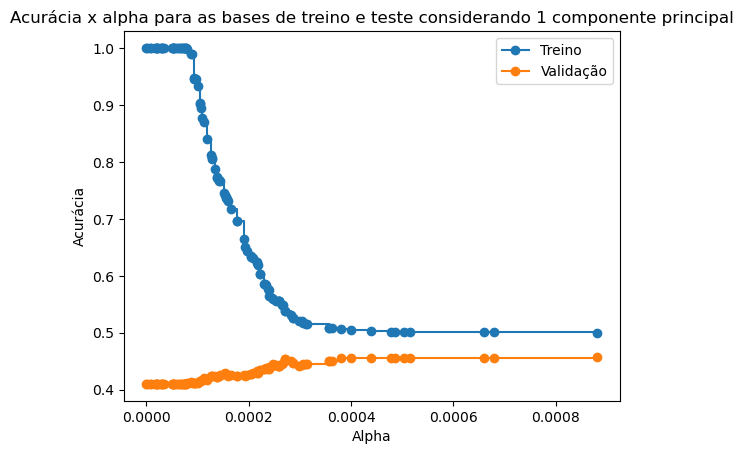

--> A acurácia do modelo na base de treino é 49.54%
--> A acurácia do modelo na base de testes é 46.93%
CPU times: total: 6.8 s
Wall time: 4.96 s


In [37]:
%%time

# Selecionando as componentes principais (ordem crescente de relevância)
cps = PCA().fit(X_train)  

# Obtendo as cps para cada conjunto de dados (de acordo com o conjunto de referência)
cps_treino = cps.transform(X_train)
cps_teste = cps.transform(X_test)

n_cps = 1 # Número de cps a serem consideradas pelo modelo

cps_train = pd.DataFrame(cps_treino[:,:n_cps], columns=['cp_'+str(n_cps)])
cps_test = pd.DataFrame(cps_teste[:,:n_cps], columns=['cp_'+str(n_cps)])

# Criando o modelo com a nova base (novos dados explicativos)
path = DecisionTreeClassifier(min_samples_leaf=30).cost_complexity_pruning_path(cps_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for _ in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=_).fit(cps_train, y_train)
    clfs.append(clf)
    
# Plot
train_score = [clf.score(cps_train, y_train) for clf in clfs]
test_score = [clf.score(cps_test, y_test) for clf in clfs]
# Figure
fig, ax = plt.subplots()
ax.set_xlabel('Alpha')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia x alpha para as bases de treino e teste considerando 1 componente principal')
nx=-10 # Para ignorar os dez últimos elementos (mais distantes)
ax.plot(ccp_alphas[:nx], train_score[:nx], marker='o', label='Treino', drawstyle='steps-post')
ax.plot(ccp_alphas[:nx], test_score[:nx], marker='o', label='Validação', drawstyle='steps-post')
ax.legend()
plt.show()


# Obtendo a curácia na base de treino e teste
ind_melhor_arvore = test_score.index(max(test_score))
melhor_arvore = clfs[ind_melhor_arvore]

accuracy_train = melhor_arvore.score(cps_train, y_train)
accuracy_test = melhor_arvore.score(cps_test, y_test)

print('--> A acurácia do modelo na base de treino é {:.2f}%'.format(accuracy_train*100))
print('--> A acurácia do modelo na base de testes é {:.2f}%'.format(accuracy_test*100))

In [11]:
# O componente princial selecionado
cps_train.head()

,cp_1
0,-5.520280
1,-5.535350
2,-5.474988
3,-5.677232
4,-5.748749


In [12]:
cps_test.head()

,cp_1
0,-2.686743
1,-4.331255
2,-4.985360
3,-5.099876
4,-5.023000


## Testando o número de componentes

Com base no código acima, teste a árvore de classificação com pelo menos as seguintes possibilidades de quantidades de componentes: ```[1, 2, 5, 10, 50]```. Avalie para cada uma delas:

- Acurácia nas bases de treino e teste
- Tempo de processamento


In [3]:
# Selecionando as componentes principais (ordem crescente de relevância)
cps = PCA().fit(X_train)  
# Obtendo as cps para cada conjunto de dados (de acordo com o conjunto de referência)
cps_treino = cps.transform(X_train)
cps_teste = cps.transform(X_test)

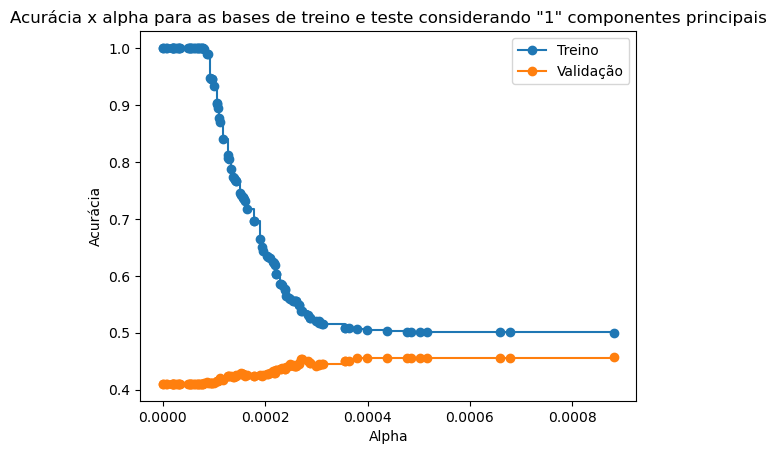

--> A acurácia do modelo na base de treino é 49.54%
--> A acurácia do modelo na base de testes é 46.93%

 >>> O tempo para a de execução do loop com n_cps=1 foi de 4.678501 segundos 



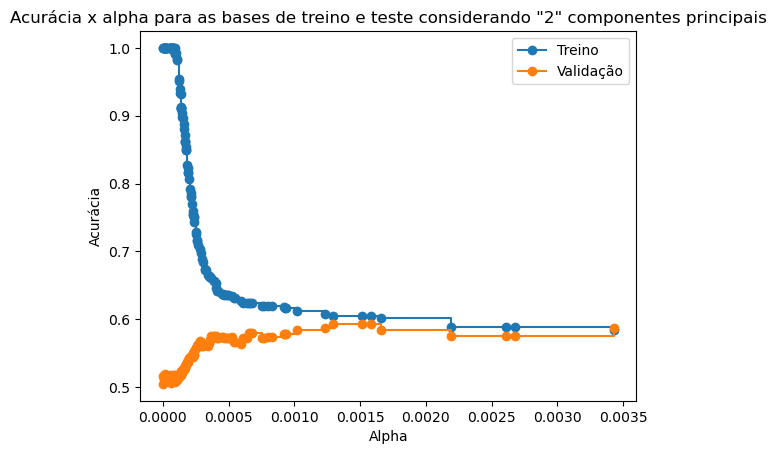

--> A acurácia do modelo na base de treino é 60.42%
--> A acurácia do modelo na base de testes é 59.25%

 >>> O tempo para a de execução do loop com n_cps=2 foi de 5.323847 segundos 



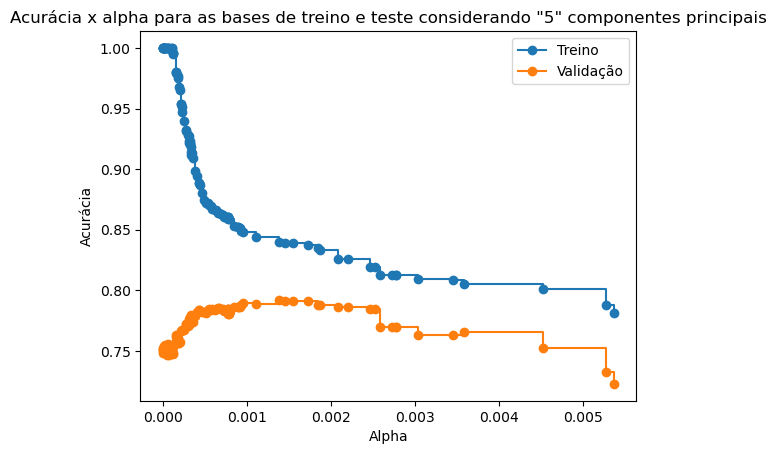

--> A acurácia do modelo na base de treino é 83.98%
--> A acurácia do modelo na base de testes é 79.17%

 >>> O tempo para a de execução do loop com n_cps=5 foi de 5.901946 segundos 



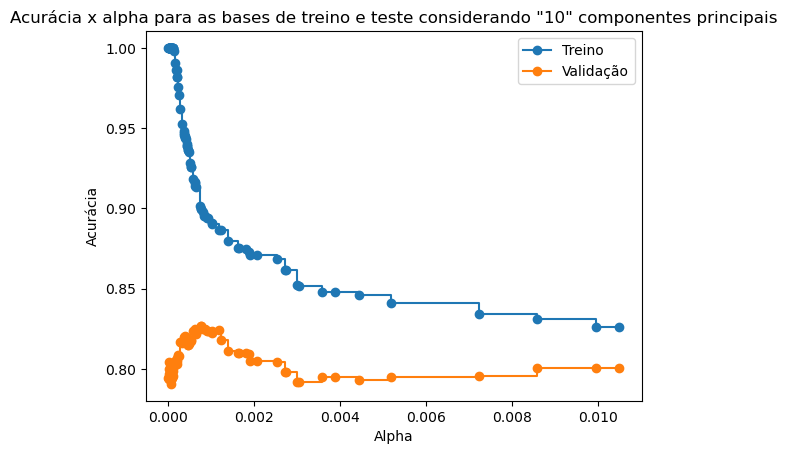

--> A acurácia do modelo na base de treino é 89.98%
--> A acurácia do modelo na base de testes é 82.69%

 >>> O tempo para a de execução do loop com n_cps=10 foi de 10.269254 segundos 



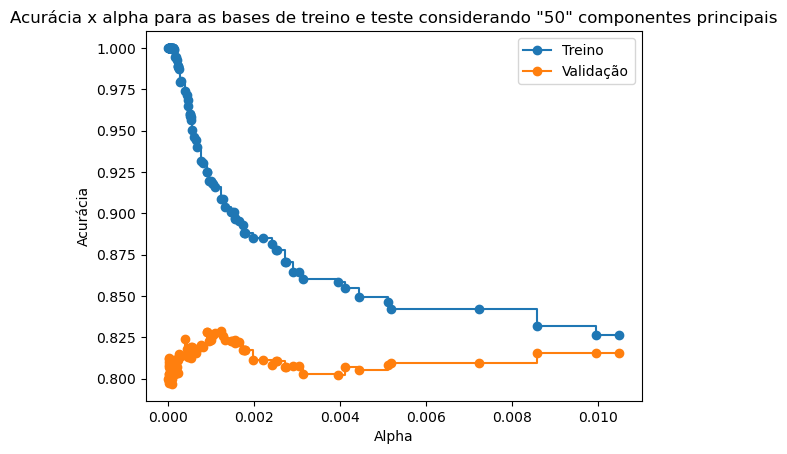

--> A acurácia do modelo na base de treino é 90.89%
--> A acurácia do modelo na base de testes é 82.90%

 >>> O tempo para a de execução do loop com n_cps=50 foi de 54.236819 segundos 

CPU times: total: 1min 20s
Wall time: 1min 20s


In [5]:
%%time

n_cps = [1, 2, 5, 10, 50] # Número de cps a serem consideradas pelo modelo

for n_cp in n_cps:
    # Avaliando o tempo por loop
    initial_time = datetime.datetime.now()
    
    # Ajustando os dados de acordo com os cps    
    colunas = ['cp_'+str(_+1) for _ in list(range(n_cp))]
    cps_train = pd.DataFrame(cps_treino[:,:n_cp], columns=colunas)
    cps_test = pd.DataFrame(cps_teste[:,:n_cp], columns=colunas)
    
    # Criando o modelo com a nova base (novos dados explicativos)
    path = DecisionTreeClassifier(random_state=1234, min_samples_leaf=30).cost_complexity_pruning_path(cps_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    clfs = []
    for _ in ccp_alphas:
        clf = DecisionTreeClassifier(ccp_alpha=_).fit(cps_train, y_train)
        clfs.append(clf)
        
    # Plot
    train_score = [clf.score(cps_train, y_train) for clf in clfs]
    test_score = [clf.score(cps_test, y_test) for clf in clfs]
    # Figure
    fig, ax = plt.subplots()
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Acurácia')
    ax.set_title('Acurácia x alpha para as bases de treino e teste considerando "{}" componentes principais'.format(n_cp))
    nx=-10 # Para ignorar os dez últimos elementos (mais distantes)
    ax.plot(ccp_alphas[:nx], train_score[:nx], marker='o', label='Treino', drawstyle='steps-post')
    ax.plot(ccp_alphas[:nx], test_score[:nx], marker='o', label='Validação', drawstyle='steps-post')
    ax.legend()
    plt.show()
    
    
    # Obtendo a curácia na base de treino e teste
    ind_melhor_arvore = len(test_score) - test_score[::-1].index(max(test_score)) - 1
    melhor_arvore = clfs[ind_melhor_arvore]
    
    accuracy_train = melhor_arvore.score(cps_train, y_train)
    accuracy_test = melhor_arvore.score(cps_test, y_test)
    
    print('--> A acurácia do modelo na base de treino é {:.2f}%'.format(accuracy_train*100))
    print('--> A acurácia do modelo na base de testes é {:.2f}%'.format(accuracy_test*100))

    # Capturando o tempo final do loop
    final_time = datetime.datetime.now()
    dt = final_time - initial_time
    print('\n >>> O tempo para a de execução do loop com n_cps={} foi de {} segundos \n'.format(n_cp, dt.total_seconds()))

## Conclua

- O que aconteceu com a acurácia?
- O que aconteceu com o tempo de processamento?

R.

- Ao executarmos a *Análise de componentes principais* (PCA) considerando múltiplos componentes é nítida a melhoria na acurácia do modelo, mas também é nítido o aumento no tempo de processamento. Para o primeiro caso, com o número de componentes igual a `1`, obtivemos uma acurácia de 49.54% nos dados de treino e 46.93% nos dados de teste, e um tempo de execução igual a 4.68 segundos. Porém, considerando o número de componentes igual a 50, foram obtidos valores acurácia sensivelmente maiores e mais significativos, 90.89% para os dados de treino e 82.90% para os dados de teste.
- É evidente que o tempo de execução entre os modelos aumentou, com cps=1 para o modelo com cps=50, porém agora temos um modelo (cps=50) mais explicativo e com uma capacidade de previsão aprimorada em relação ao primeiro.
- Um modelo genérico e sem a redução de dimensionalidade realizada por meio do PCA teria um tempo de execução muito maior, como pode ser visto abaixo.


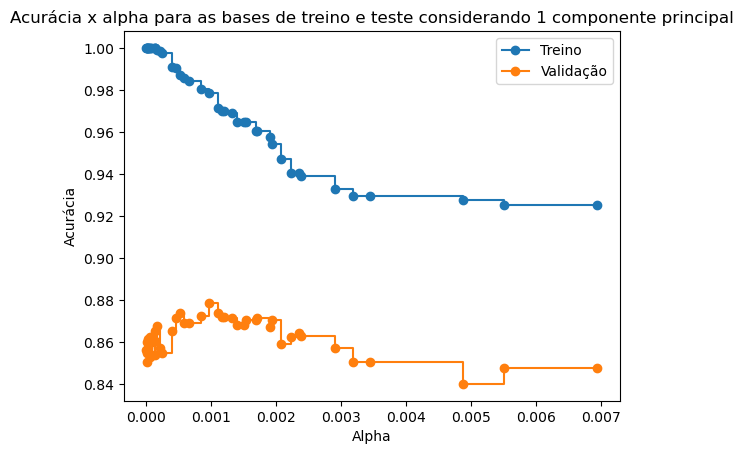

--> A acurácia do modelo na base de treino é 97.84%
--> A acurácia do modelo na base de testes é 87.85%
CPU times: total: 4min 16s
Wall time: 4min 17s


In [15]:
%%time

# Modelo geral, sem redução de dimensionalidade (PCA) 
# [Considerando a mesma metodologia dos casos anteriores]

# Criando o modelo com a nova base (novos dados explicativos)
path = DecisionTreeClassifier(min_samples_leaf=30).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for _ in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=_).fit(X_train, y_train)
    clfs.append(clf)
    
# Plot
train_score = [clf.score(X_train, y_train) for clf in clfs]
test_score = [clf.score(X_test, y_test) for clf in clfs]
# Figure
fig, ax = plt.subplots()
ax.set_xlabel('Alpha')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia x alpha para as bases de treino e teste considerando 1 componente principal')
nx=-10 # Para ignorar os dez últimos elementos (mais distantes)
ax.plot(ccp_alphas[:nx], train_score[:nx], marker='o', label='Treino', drawstyle='steps-post')
ax.plot(ccp_alphas[:nx], test_score[:nx], marker='o', label='Validação', drawstyle='steps-post')
ax.legend()
plt.show()


# Obtendo a curácia na base de treino e teste
ind_melhor_arvore = test_score.index(max(test_score))
melhor_arvore = clfs[ind_melhor_arvore]

accuracy_train = melhor_arvore.score(X_train, y_train)
accuracy_test = melhor_arvore.score(X_test, y_test)

print('--> A acurácia do modelo na base de treino é {:.2f}%'.format(accuracy_train*100))
print('--> A acurácia do modelo na base de testes é {:.2f}%'.format(accuracy_test*100))

- Como podemos ver, o tempo de execução considerando todas as variáveis foi de 4min e 17s (~ 4.76 vezes maior do que utilizando os 50 componentes principais obtidos através do PCA). É claro, aqui temos uma acurácia maior nos dados de treino e teste, mas talvez valores tão bons quanto ou próximos a estes possam ser atingidos utilizando PCA e com um tempo de execução satisfatório, uma vez que para grandes conjuntos de dados (big data) considerar todas as variáveis pode ser inviável.